# Model : Autoencoder

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from data_prep import DataPrep
from data_plotting import DataPlotting

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



## <ins>Loading and processing data</ins>

In [2]:
file_path = './data/v2_CLD/AE_3C_1D/200716-174206_174209_174205'
data_prep = DataPrep(file_path)
data = data_prep.load_data(2, 'timestamp', True)

Data  1  : 
./data/v2_CLD/AE_3C_1D/200716-174206_174209_174205\c.txt loaded.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792477 entries, 2020-07-16 08:42:07.312000 to 2020-07-16 09:06:12.722000
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   mag_x        792477 non-null  float64
 1   mag_y        792477 non-null  float64
 2   mag_z        792477 non-null  float64
 3   mag_acc      792477 non-null  int64  
 4   acc_x        792477 non-null  float64
 5   acc_y        792477 non-null  float64
 6   acc_z        792477 non-null  float64
 7   acc_acc      792477 non-null  int64  
 8   gyro_x       792477 non-null  float64
 9   gyro_y       792477 non-null  float64
 10  gyro_z       792477 non-null  float64
 11  gyro_acc     792477 non-null  int64  
 12  pos_lat      792477 non-null  float64
 13  pos_lng      792477 non-null  float64
 14  pos_acc      792477 non-null  float64
 15  activity     792477 non-null

In [3]:
data = data_prep.total_intensity()

In [4]:
data = data_prep.downsampling('250ms')

In [5]:
data = data_prep.normalise(1)

In [6]:
data[0].head()

,mag_x,mag_y,mag_z,mag_f,mag_acc,acc_x,acc_y,acc_z,acc_acc,gyro_x,gyro_y,gyro_z,gyro_acc,pos_lat,pos_lng,pos_acc,mag_f_norm
timestamp,,,,,,,,,,,,,,,,,
2020-07-16 08:42:07.250,-26.852778,31.494445,-29.322222,50.834755,3.0,-1.118641,-3.751132,10.416756,3.0,-0.603842,-0.576057,-0.185889,3.0,35.150231,129.004071,22.279,0.040452
2020-07-16 08:42:07.500,-26.535196,30.893855,-29.544134,50.470112,3.0,-0.219023,-1.886745,9.701967,3.0,1.227637,-0.127939,0.499175,3.0,35.150231,129.004070,22.279,0.040105
2020-07-16 08:42:07.750,-26.716667,24.707639,-35.475000,50.852372,3.0,0.057311,1.379226,9.226048,3.0,0.221575,-0.181960,0.109071,3.0,35.150231,129.004070,22.279,0.040468
2020-07-16 08:42:08.000,-28.806383,23.295745,-34.617731,50.717888,3.0,0.690549,1.134818,9.991301,3.0,0.611258,-0.312470,0.069023,3.0,35.150231,129.004070,22.279,0.040340
2020-07-16 08:42:08.250,-30.427858,20.094286,-35.157143,50.742243,3.0,2.083665,2.844953,8.689644,3.0,0.325324,-0.507127,-0.055470,3.0,35.150231,129.004070,22.279,0.040364


In [7]:
data[1].head()

,mag_x,mag_y,mag_z,mag_f,mag_acc,acc_x,acc_y,acc_z,acc_acc,gyro_x,gyro_y,gyro_z,gyro_acc,pos_lat,pos_lng,pos_acc,mag_f_norm
timestamp,,,,,,,,,,,,,,,,,
2020-07-16 08:42:13.500,-64.873915,53.520244,-18.878774,86.207976,2.0,-2.786658,8.044915,7.462714,3.0,-0.057514,-0.673525,-0.057473,3.0,35.150310,129.003927,9.618000,0.033725
2020-07-16 08:42:13.750,-70.062448,55.364075,-16.743962,90.863407,2.0,-1.410946,5.606661,7.090550,3.0,-0.395289,-0.450018,0.186151,3.0,35.150310,129.003927,9.618000,0.035754
2020-07-16 08:42:14.000,-72.437242,58.415687,-17.969406,94.782245,2.0,-0.925708,5.359957,8.233162,3.0,-0.157223,0.022841,0.035097,3.0,35.150310,129.003927,9.618000,0.037463
2020-07-16 08:42:14.250,-71.200442,59.205820,-18.999702,94.537722,2.0,-0.822154,5.291569,8.305169,3.0,0.055568,0.084165,0.042251,3.0,35.150310,129.003927,9.618000,0.037356
2020-07-16 08:42:14.500,-71.326553,59.226970,-19.194660,94.683533,2.0,-0.954372,4.854390,8.180255,3.0,-0.100496,-0.153049,0.006132,3.0,35.150311,129.003919,10.036232,0.037420


In [8]:
data[2].head()

,mag_x,mag_y,mag_z,mag_f,mag_acc,acc_x,acc_y,acc_z,acc_acc,gyro_x,gyro_y,gyro_z,gyro_acc,pos_lat,pos_lng,pos_acc,mag_f_norm
timestamp,,,,,,,,,,,,,,,,,
2020-07-16 08:42:05.750,-24.905435,38.434783,-43.786957,63.387402,3.0,2.525375,0.196650,9.596832,3.0,0.424172,-0.656573,-0.024142,3.0,35.150136,128.99892,1700.0,0.086910
2020-07-16 08:42:06.000,-16.702143,33.557144,-47.869286,61.246915,3.0,1.266097,1.576992,9.034093,3.0,0.715074,1.366255,-0.290208,3.0,35.150136,128.99892,1700.0,0.083673
2020-07-16 08:42:06.250,-3.913971,27.594853,-49.277206,56.676356,3.0,-1.446846,1.859828,6.703879,3.0,-1.149600,-0.190878,0.145362,3.0,35.150136,128.99892,1700.0,0.076762
2020-07-16 08:42:06.500,2.356250,54.971876,-54.037501,77.820761,3.0,-0.157559,-3.091373,11.873772,3.0,-0.849607,0.286165,1.074935,3.0,35.150136,128.99892,1700.0,0.108735
2020-07-16 08:42:06.750,10.020134,50.638256,-53.584565,74.975216,3.0,-0.618869,-0.729468,9.612053,3.0,0.796668,-0.641497,-0.617553,3.0,35.150136,128.99892,1700.0,0.104432


#### Visualizing total intensity

In [9]:
data_plotting = DataPlotting()

dir_name = 'AE_3C_1D'
file_name = '200716-174206_174209_174205'

Data 1 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 2 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 3 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 



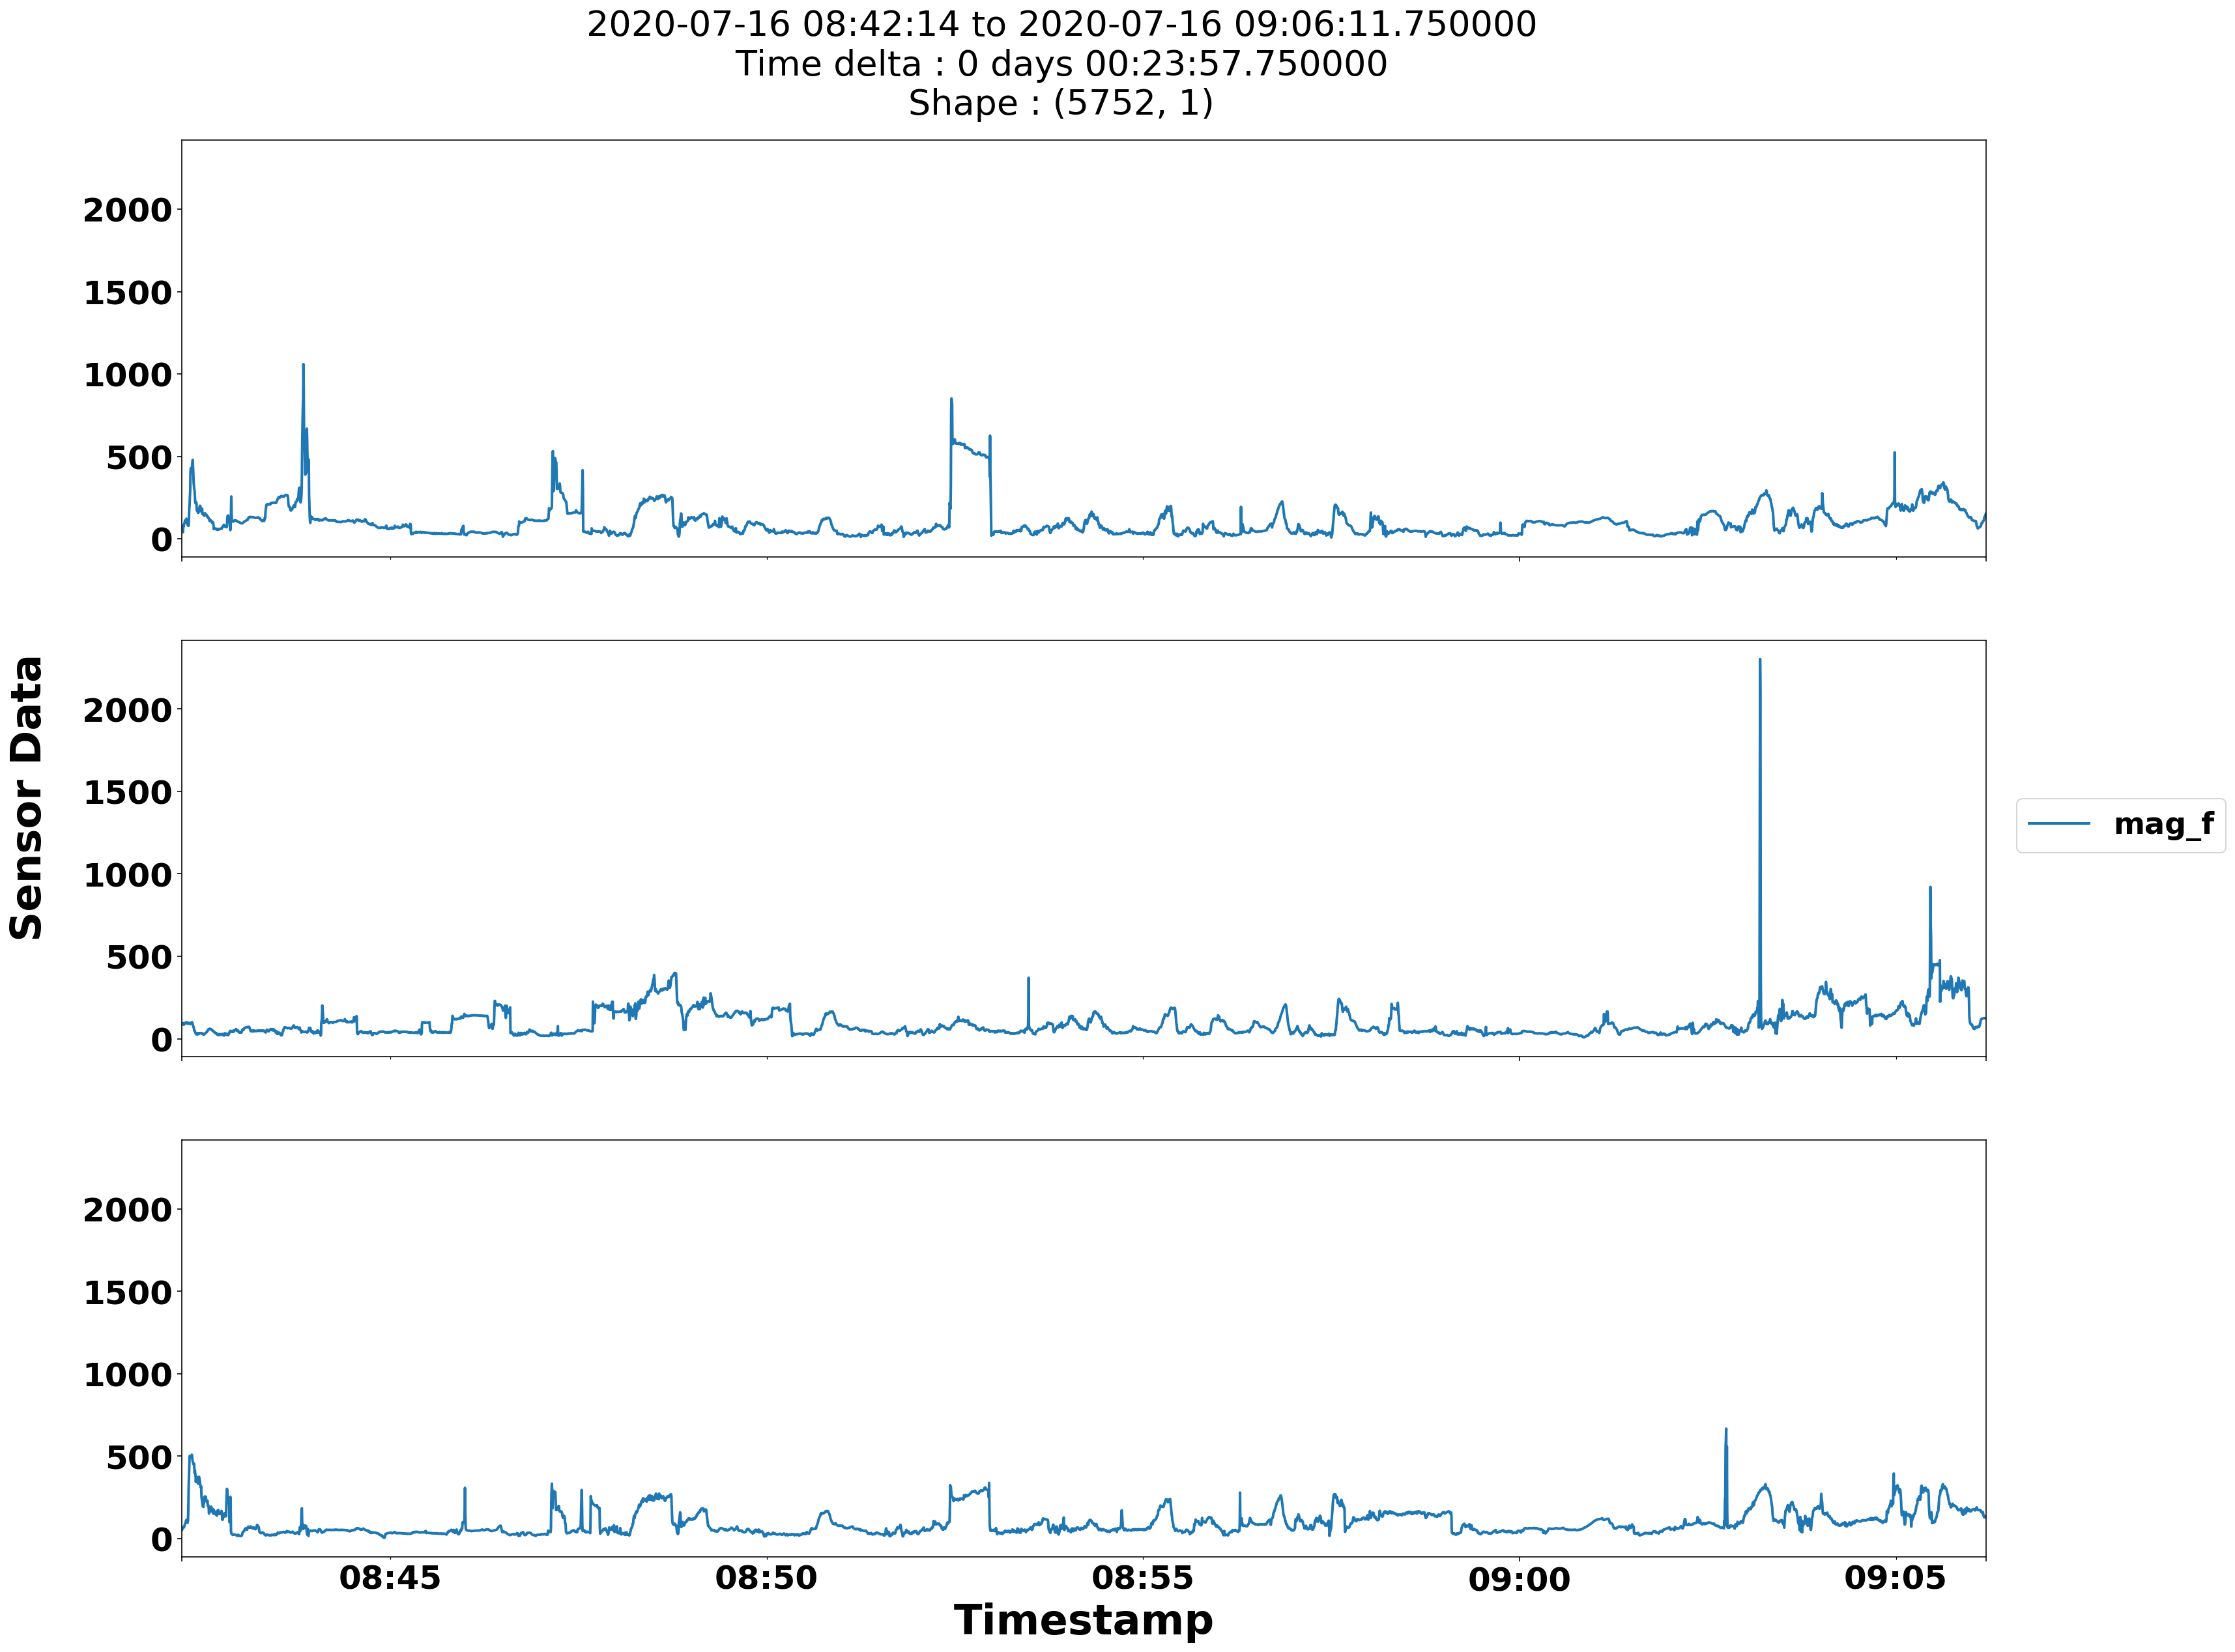

In [10]:
data_display = ['mag_f']
time_from = "2020-07-16 08:42:14"
time_to = "2020-07-16 09:06:11"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display,
                             'Timestamp', 'Sensor Data', (23, 0.894), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_1ti(ds)', False)

Data 1 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 2 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 

Data 3 : 
Start :
 2020-07-16 08:42:14
End :
 2020-07-16 09:06:11.750000
Time delta :
 0 days 00:23:57.750000
Shape :
 (5752, 1) 



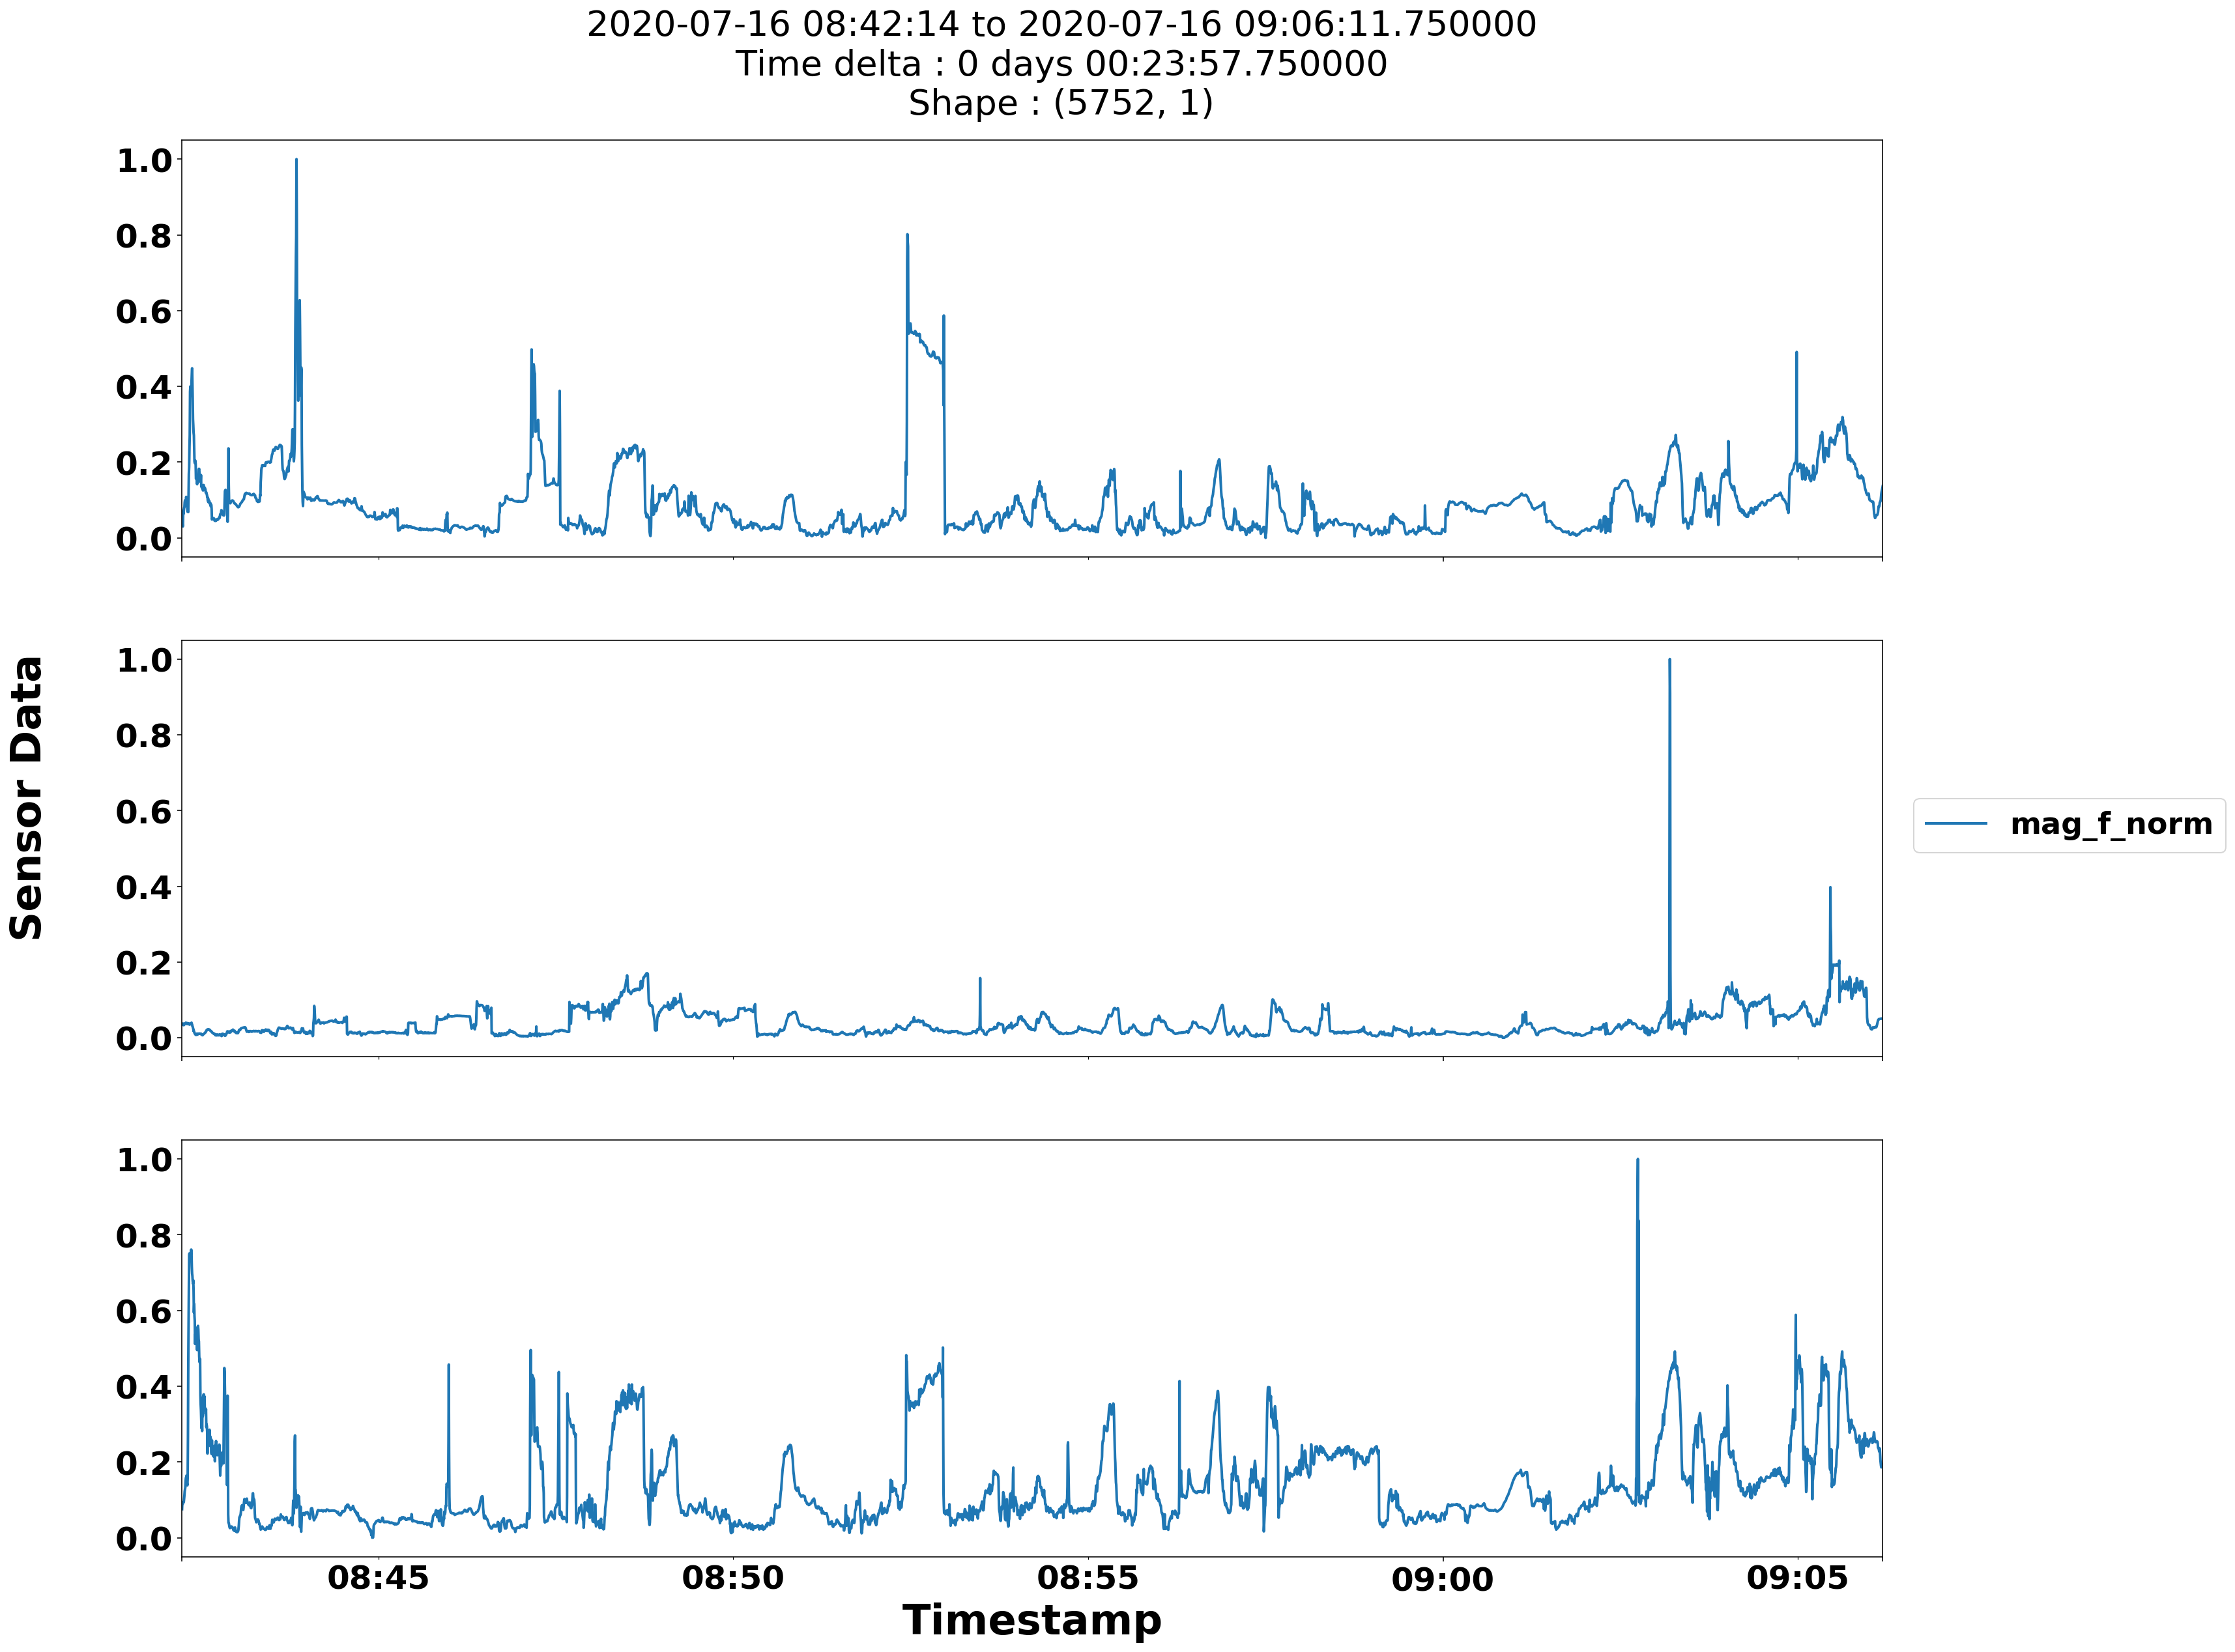

In [11]:
data_display = ['mag_f_norm']
time_from = "2020-07-16 08:42:14"
time_to = "2020-07-16 09:06:11"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display, 
                             'Timestamp', 'Sensor Data', (23, 0.85), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_1tin(ds)', False)

Data 1 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:55:00.750000
Time delta :
 0 days 00:05:00.750000
Shape :
 (1204, 1) 

Data 2 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:55:00.750000
Time delta :
 0 days 00:05:00.750000
Shape :
 (1204, 1) 

Data 3 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:55:00.750000
Time delta :
 0 days 00:05:00.750000
Shape :
 (1204, 1) 



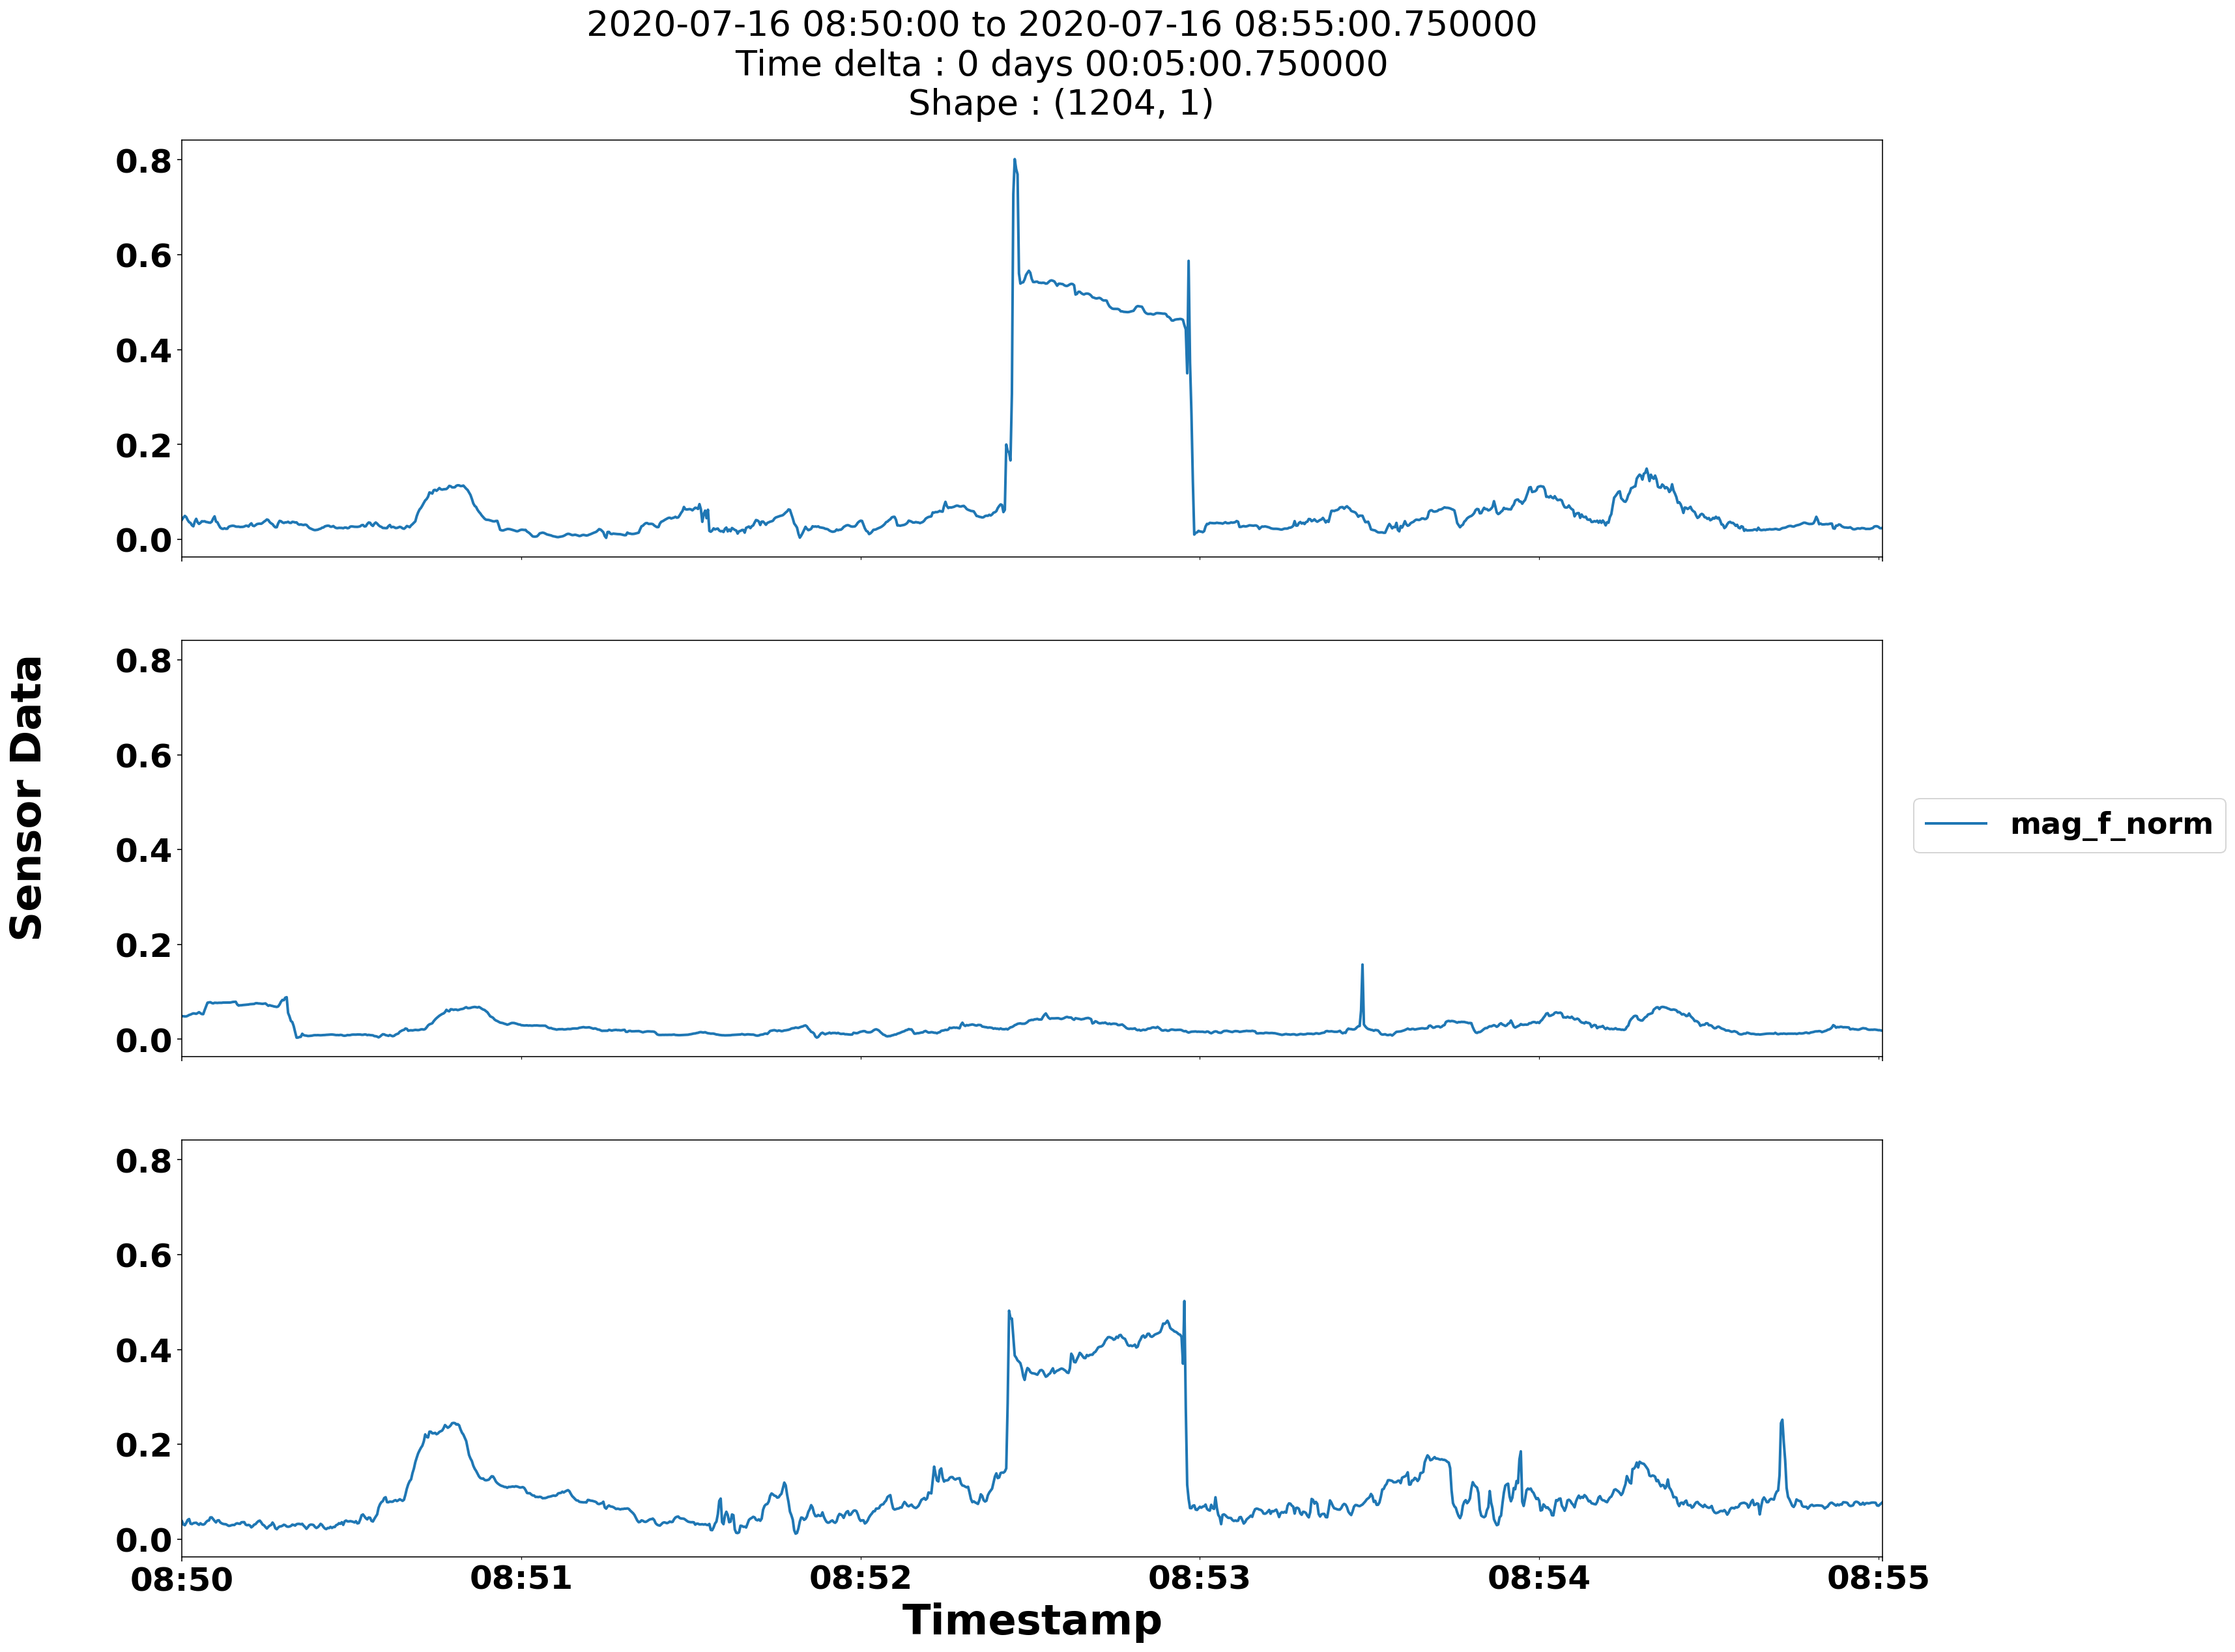

In [12]:
data_display = ['mag_f_norm']
time_from = "2020-07-16 08:50:00"
time_to = "2020-07-16 08:55:00"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display, 
                             'Timestamp', 'Sensor Data', (23, 0.85), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_2tin(ds)', False)

Data 1 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:52:00.750000
Time delta :
 0 days 00:02:00.750000
Shape :
 (484, 1) 

Data 2 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:52:00.750000
Time delta :
 0 days 00:02:00.750000
Shape :
 (484, 1) 

Data 3 : 
Start :
 2020-07-16 08:50:00
End :
 2020-07-16 08:52:00.750000
Time delta :
 0 days 00:02:00.750000
Shape :
 (484, 1) 



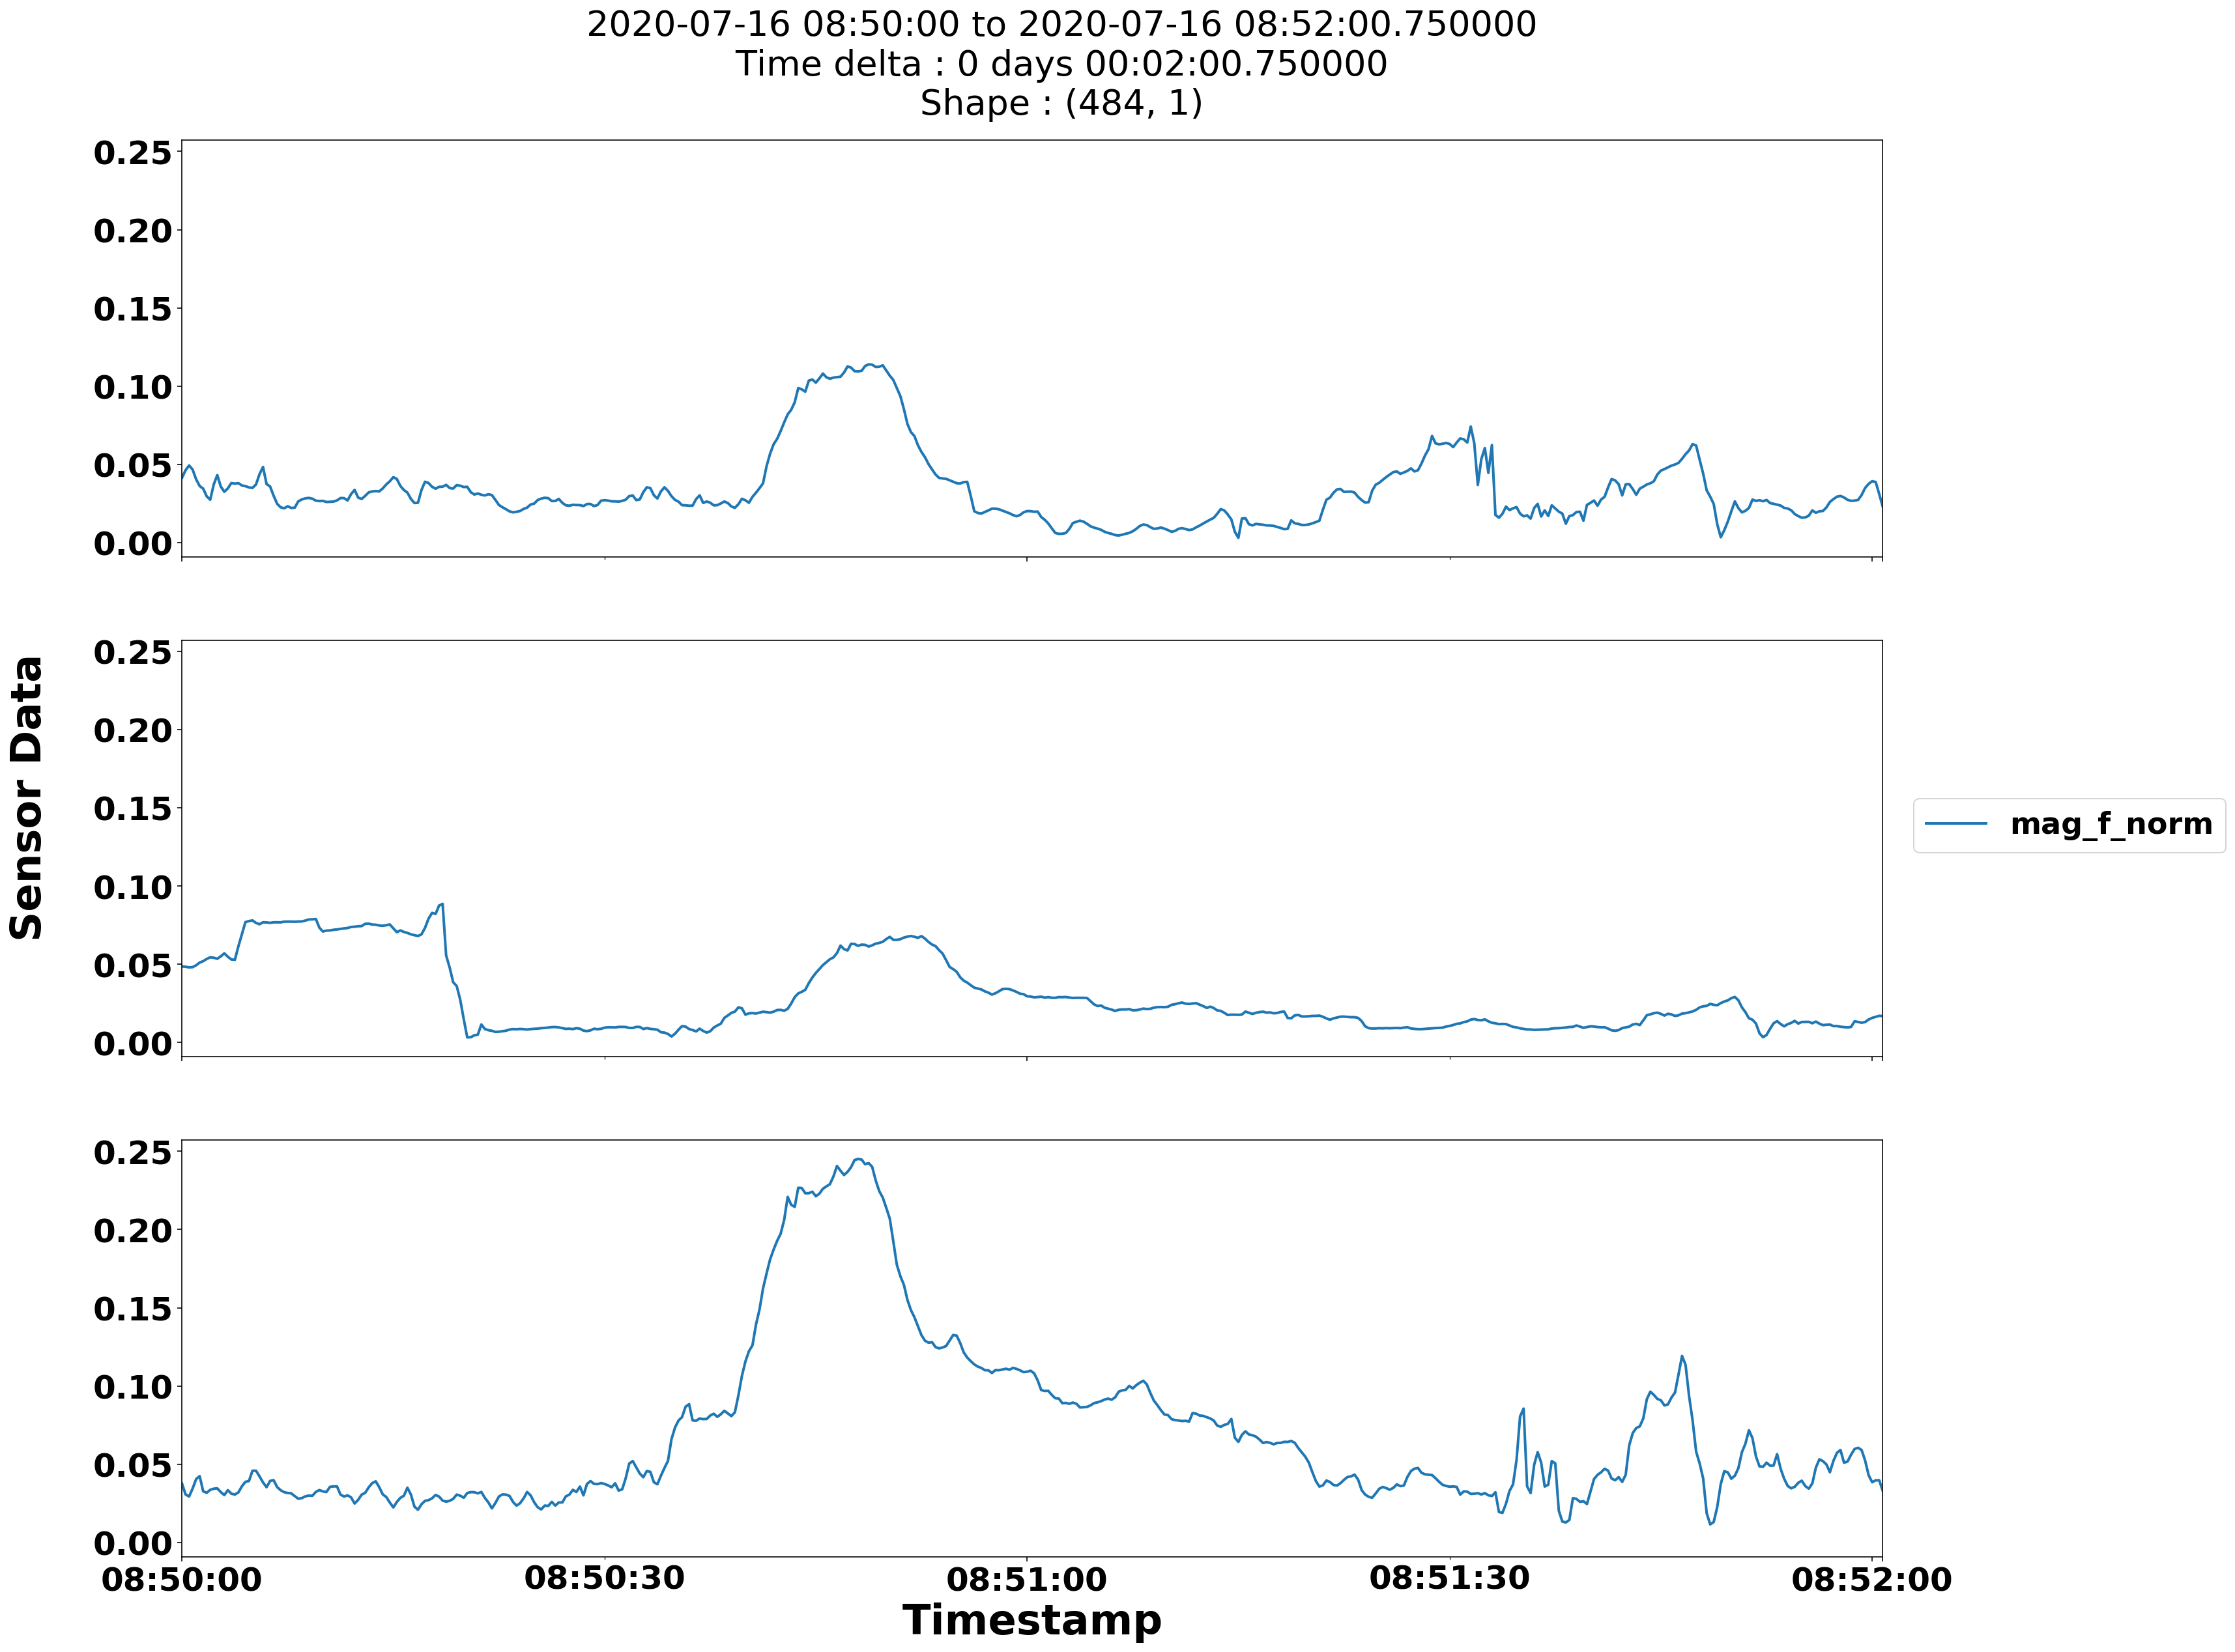

In [13]:
data_display = ['mag_f_norm']
time_from = "2020-07-16 08:50:00"
time_to = "2020-07-16 08:52:00"
data_plotting.plot_data_comp(data, (time_from, time_to), data_display,
                             'Timestamp', 'Sensor Data', (23, 0.85), 27, (25, 20),
                             dir_name, '(pp)' + file_name + '_st_3tin(ds)', False)

### Generating training data

In [14]:
window = 480
data_train_raw = np.array(data[0]["2020-07-16 08:50:00":"2020-07-16 08:55:00"]['mag_f_norm'])

# GPU
data_train = data_prep.training_matrix_GPU(data_train_raw, window, 10)

# CPU
# data_train = data_prep.training_matrix_CPU(data_train_raw, window, 10)

Data shape :  (1204,)

Generating training data (GPU)...
Training data shape :  (7250, 480)


### Generating test data

In [15]:
data_test_1 = data[1]["2020-07-16 08:50:00":"2020-07-16 08:52:00"][['mag_f_norm']].values
data_test_1 = data_test_1[0:window]
data_test_1 = data_test_1.reshape(1,len(data_test_1))

print(data_test_1.shape)
# print('\n', data_test)

(1, 480)


In [16]:
data_test_2 = data[2]["2020-07-16 08:50:00":"2020-07-16 08:52:00"][['mag_f_norm']].values
data_test_2 = data_test_2[0:window]
data_test_2 = data_test_2.reshape(1,len(data_test_2))

print(data_test_2.shape)
# print('\n', data_test)

(1, 480)


## <ins>Training and testing</ins>

In [17]:
from train import Train

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [18]:
latent_dim = 10
epochs=100
batch_size=40
parent_dir = 'model1_ae/AE_3C_1D/200716-174206_174209_174205'

train = Train(data_train)
autoencoder, encoder, decoder, history = train.model1_ae(parent_dir, 'check_point',
                                                         window, latent_dim, epochs, batch_size)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480)]             0         
_________________________________________________________________
dense (Dense)                (None, 60)                28860     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                610       
_________________________________________________________________
dense_2 (Dense)              (None, 60)                660       
_________________________________________________________________
dense_3 (Dense)              (None, 480)               29280     
Total params: 59,410
Trainable params: 59,410
Non-trainable params: 0
_________________________________________________________________
Train on 7250 samples
Epoch 1/100
6800/7250 [===========================>..] - ETA: 0s - loss: 0.0331
Epoch 00001: sa

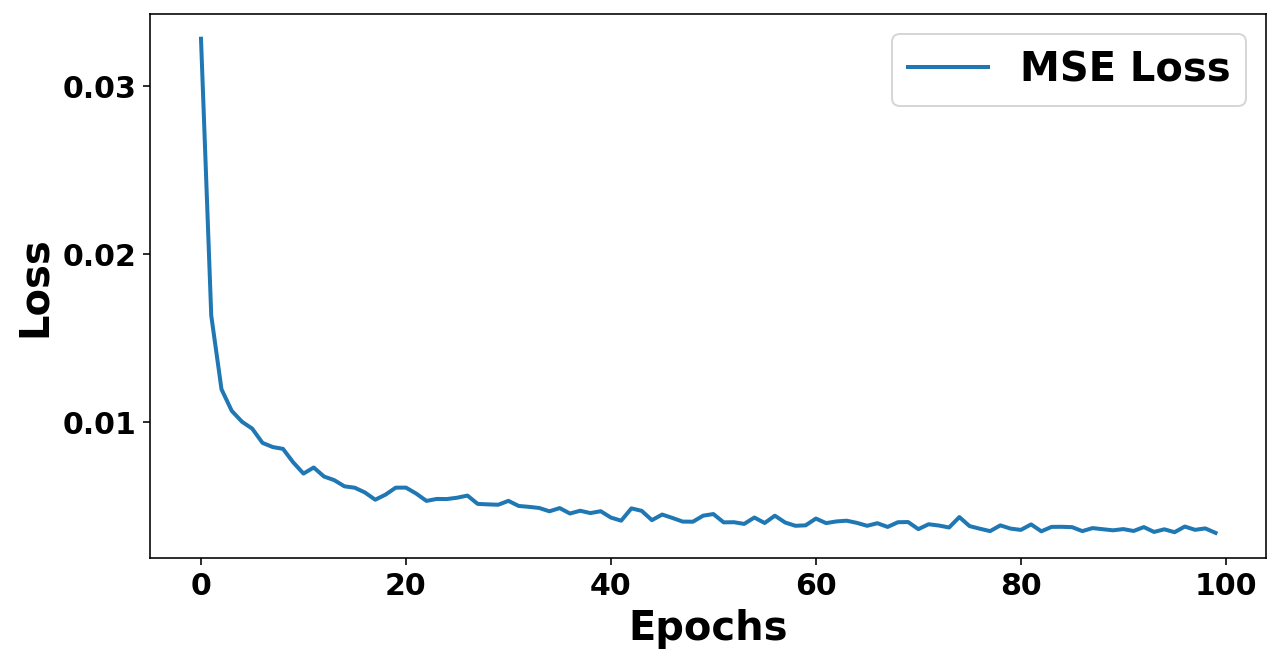

In [19]:
history_dict = history.history
loss_values = history_dict['loss']
hist_plot = pd.DataFrame({'MSE Loss': loss_values})

data_plotting.plot_hist(hist_plot, 'Epochs', 'Loss', 20)

In [20]:
latent_vector_1 = encoder.predict(data_test_1)
reconstructed_data_1 = decoder.predict(latent_vector_1)
mse_1 = mean_squared_error(data_test_1, reconstructed_data_1)

print('MSE test data (s1) : ', mse_1)

MSE test data (s1) :  0.0014054268423117273


In [21]:
latent_vector_2 = encoder.predict(data_test_2)
reconstructed_data_2 = decoder.predict(latent_vector_2)
mse_2 = mean_squared_error(data_test_2, reconstructed_data_2)

print('MSE test data (s2) : ', mse_2)

MSE test data (s2) :  0.0016382558224576369


In [22]:
description = '%s-60-%s-60-%s\nrelu \nadam \nmse \nbatch_size=%s\nepochs=%s' % (window, latent_dim, window, batch_size, epochs)
train.model_ae_save(autoencoder, encoder, decoder, history, parent_dir, '0p0014-16', description)

#### Plotting result

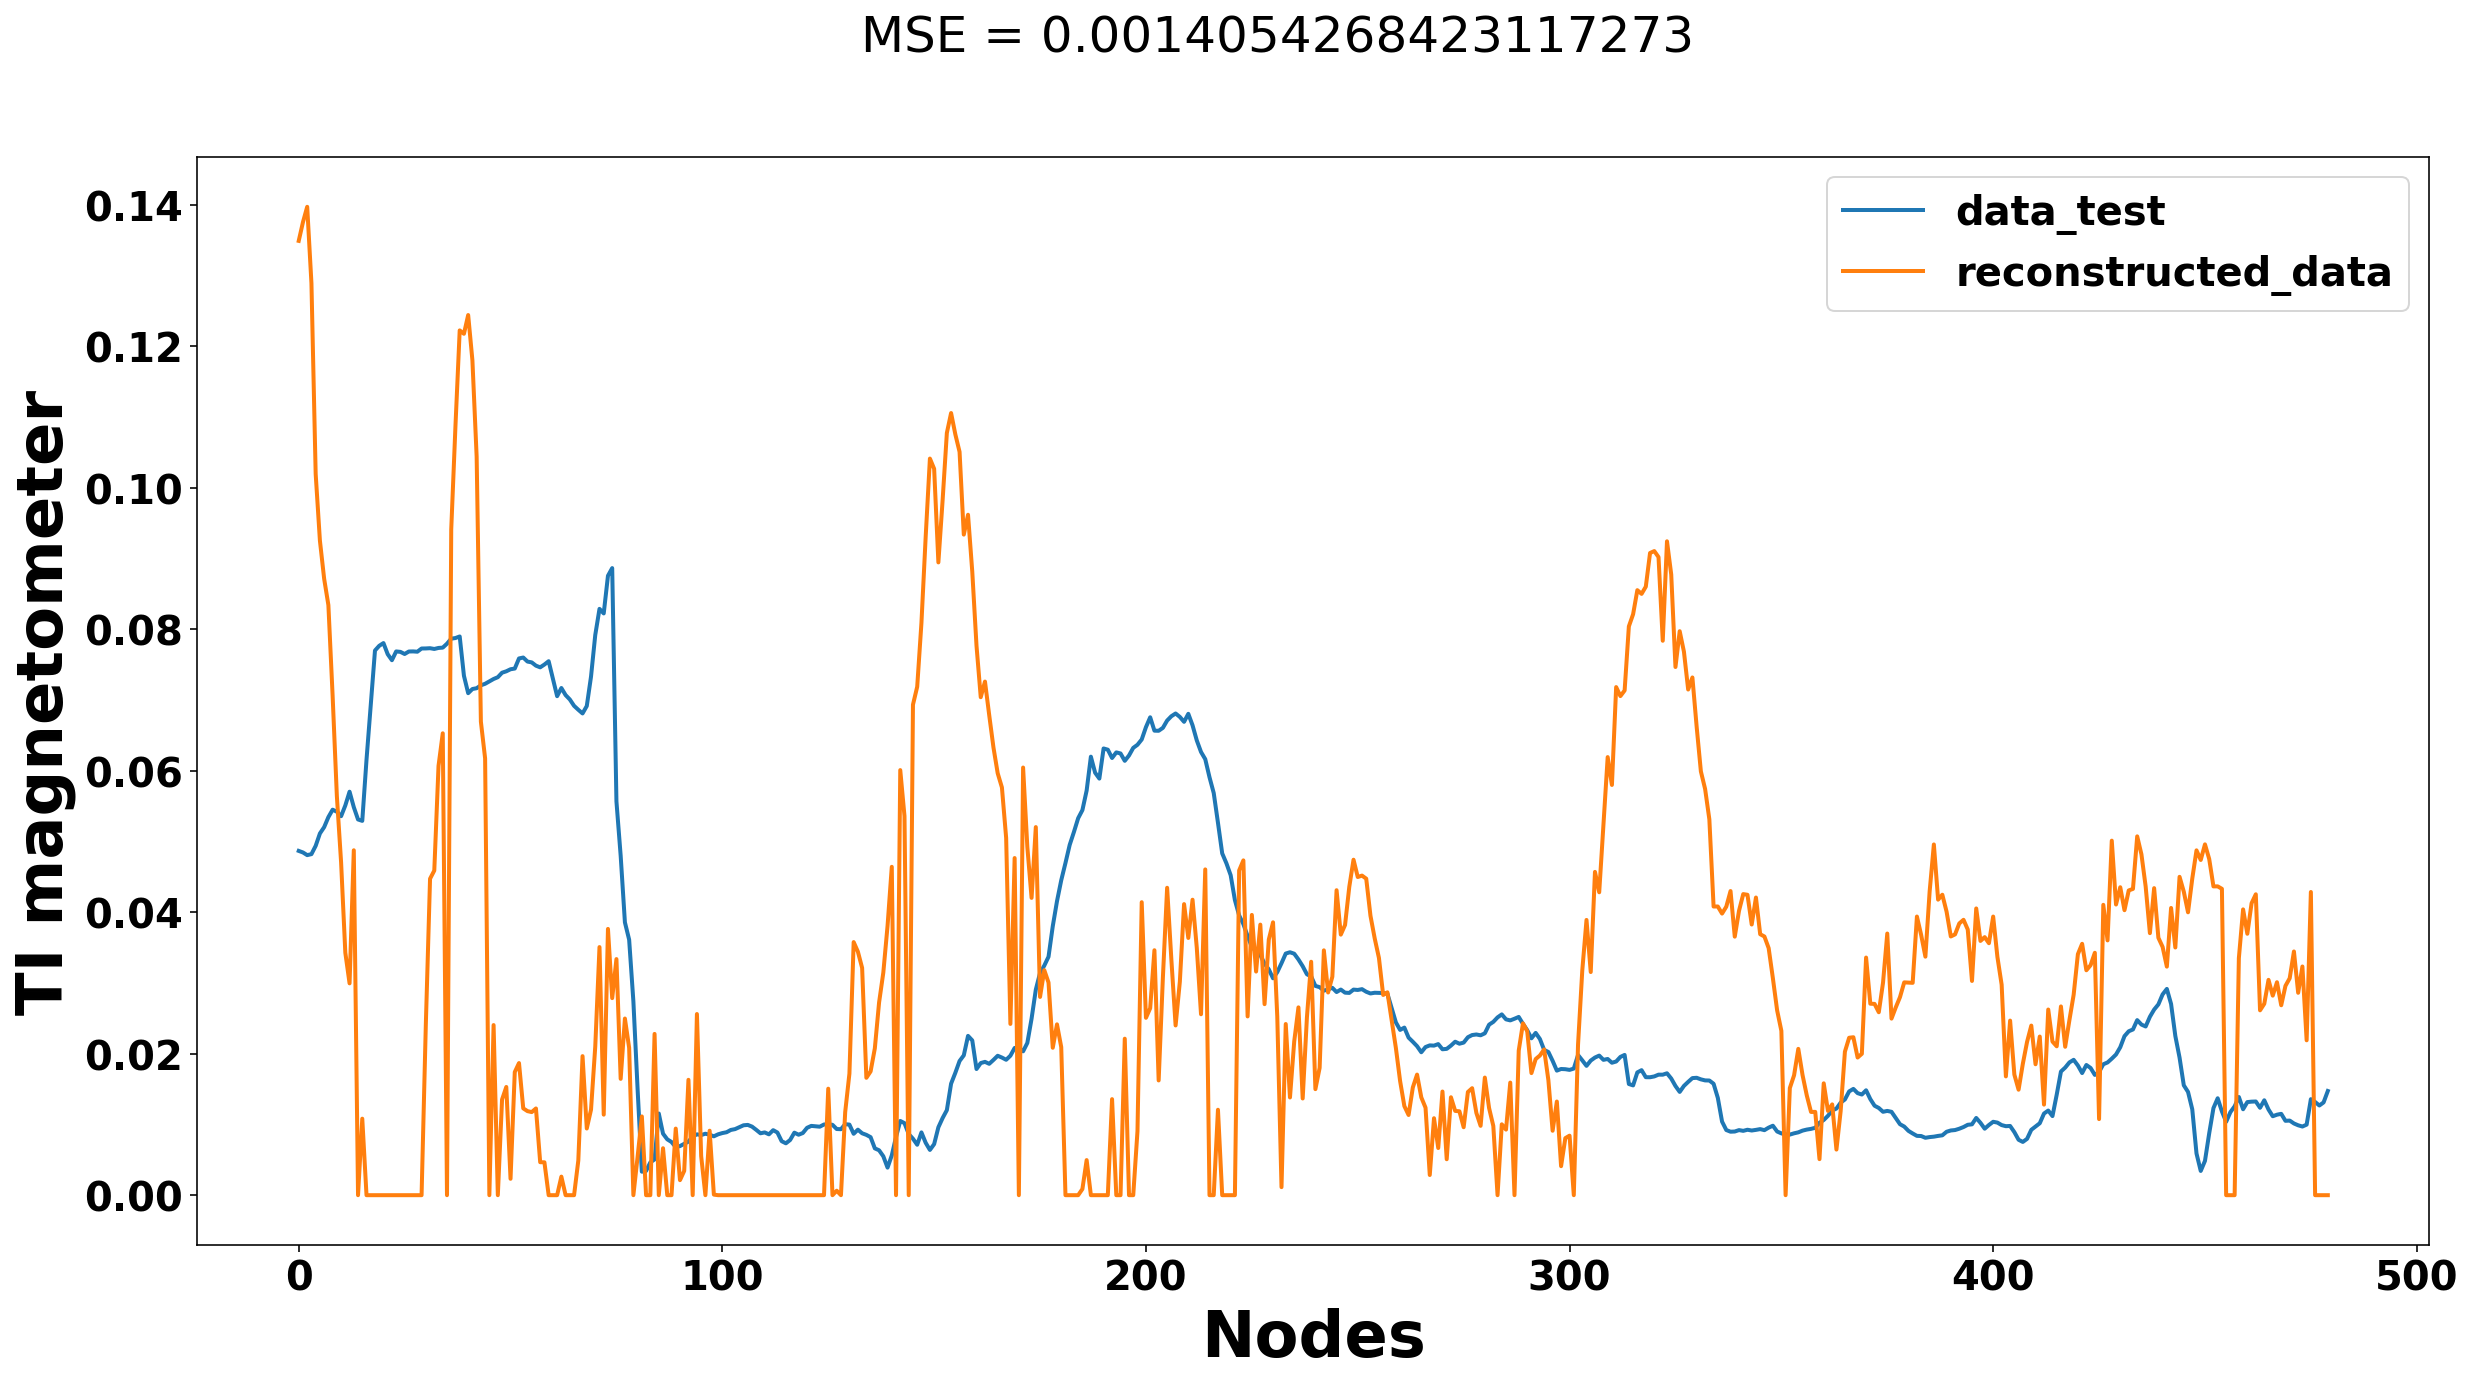

In [23]:
result_plot_1 = pd.DataFrame({'data_test': data_test_1[0], 'reconstructed_data': reconstructed_data_1[0]})
data_plotting.plot_result(result_plot_1, 'Nodes', 'TI magnetometer', 20, parent_dir, '0p0014-16', 'same_location_s1', mse_1)

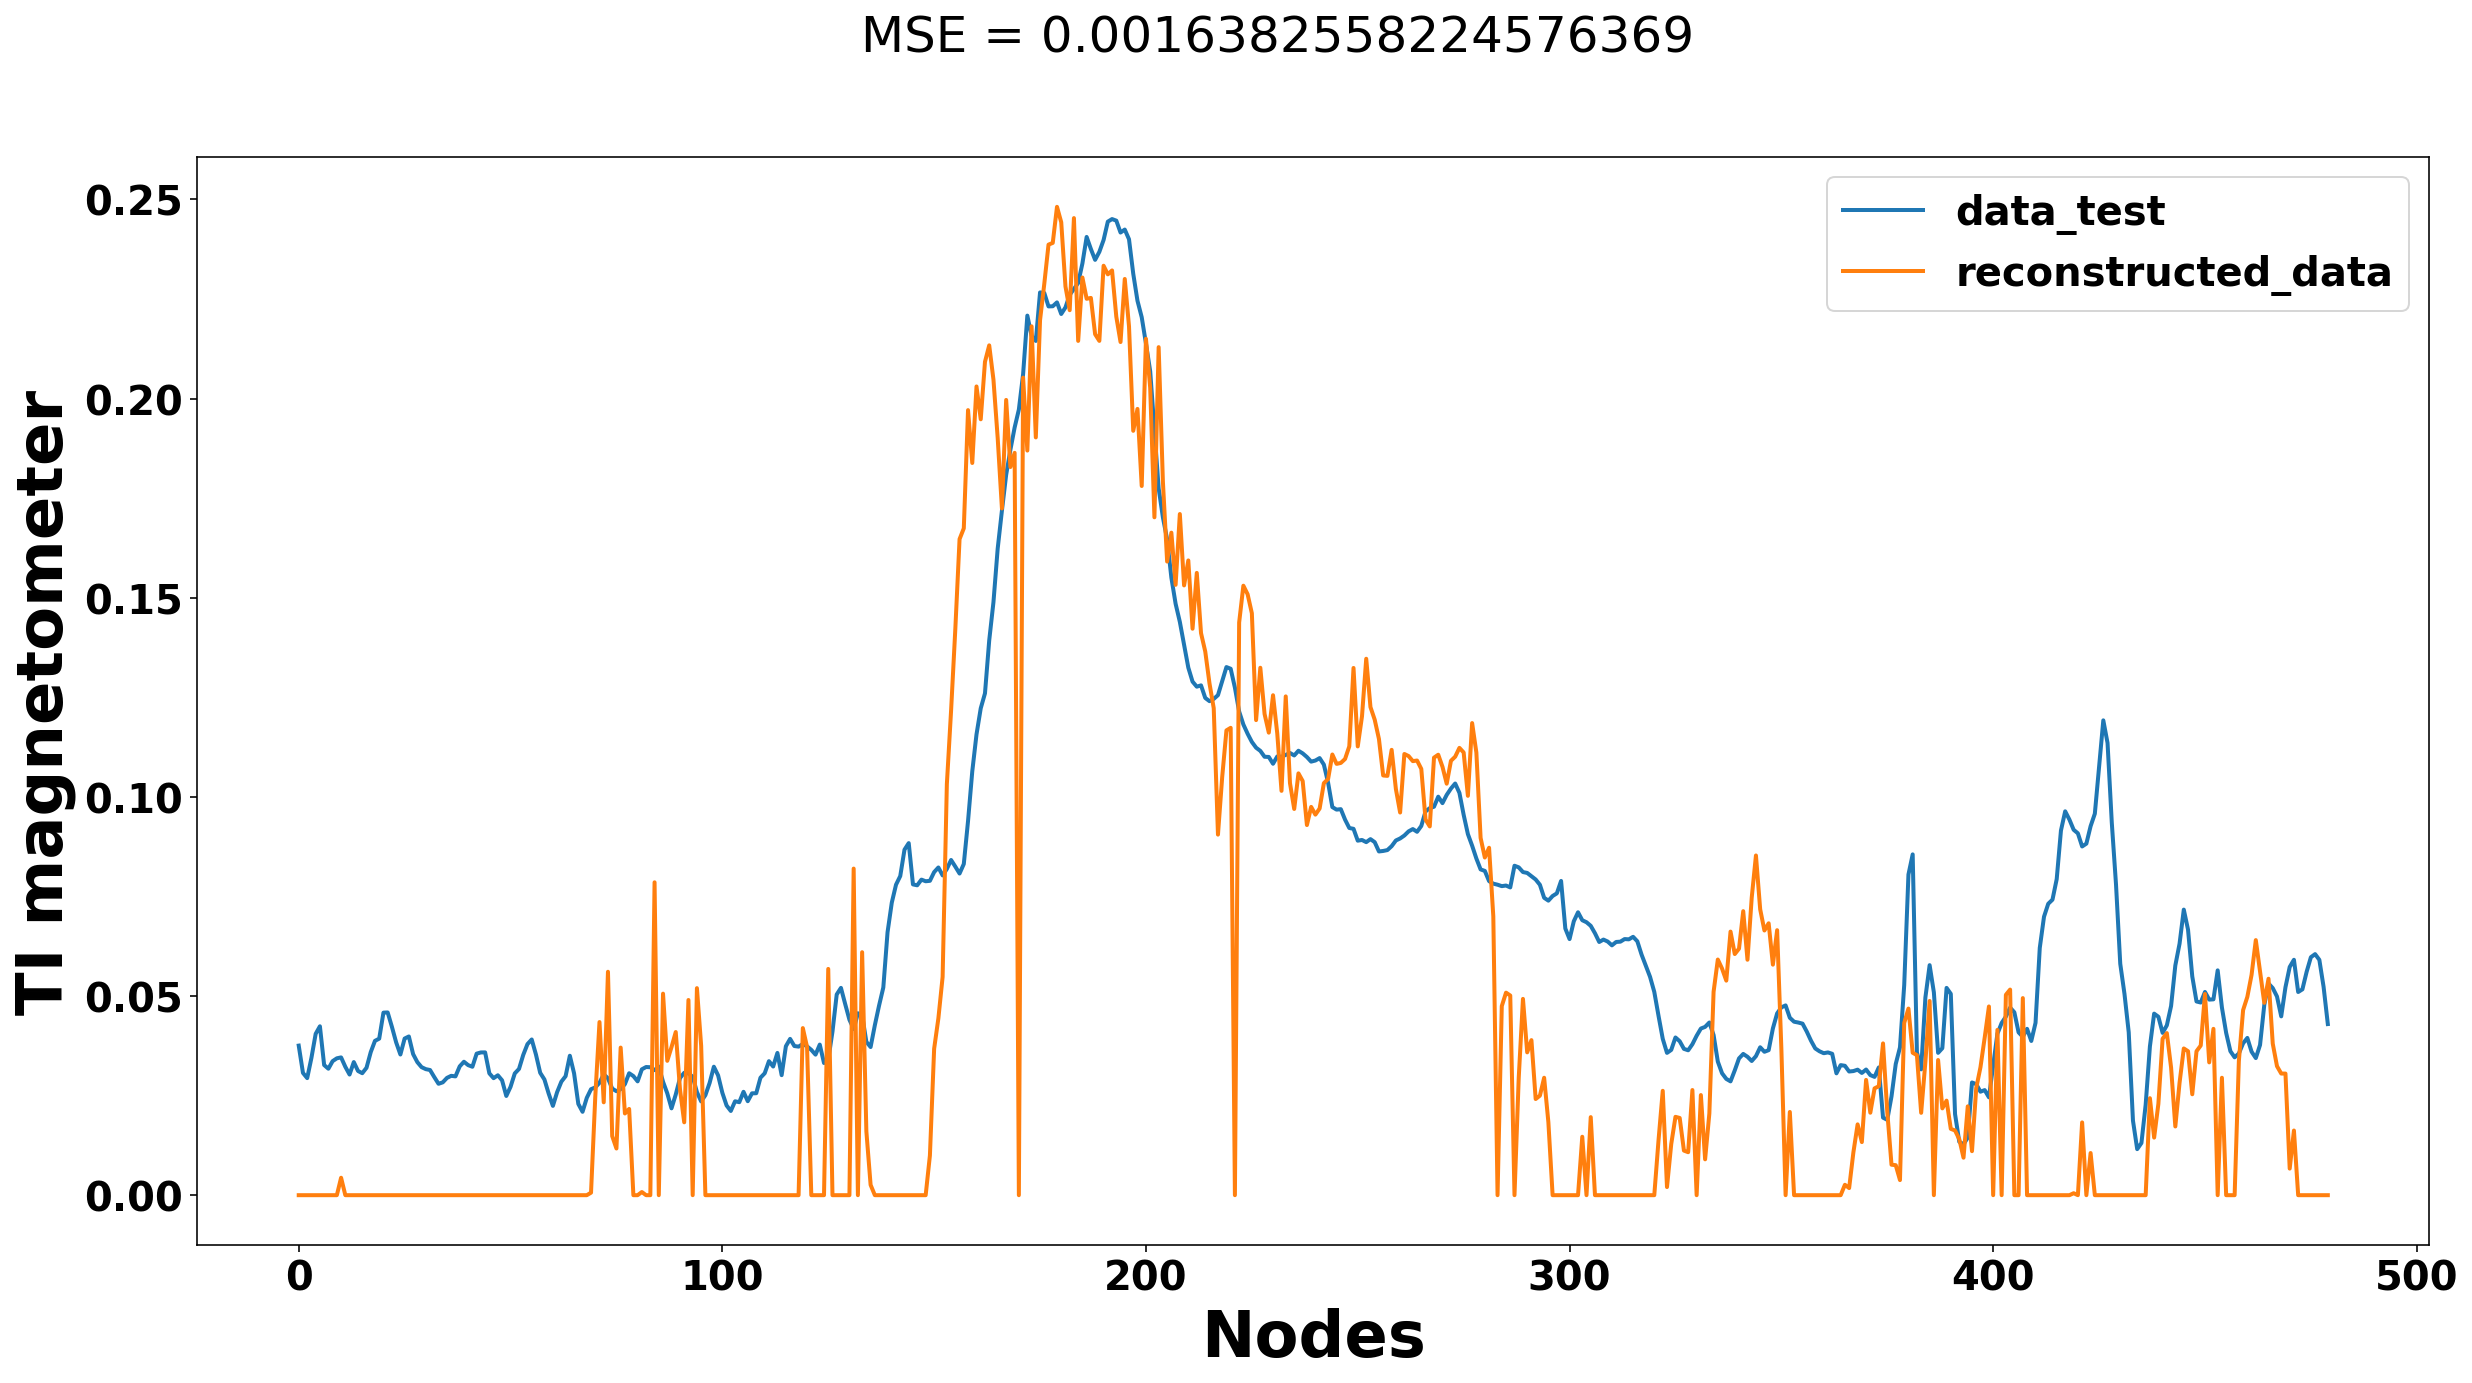

In [24]:
result_plot_2 = pd.DataFrame({'data_test': data_test_2[0], 'reconstructed_data': reconstructed_data_2[0]})
data_plotting.plot_result(result_plot_2, 'Nodes', 'TI magnetometer', 20, parent_dir, '0p0014-16', 'same_location_s2', mse_2)

### Test with false data

In [25]:
data_test_false = data[2]["2020-07-16 09:02:00":"2020-07-16 09:04:00"][['mag_f_norm']].values
data_test_false = data_test_false[0:window]
data_test_false = data_test_false.reshape(1,len(data_test_false))

print(data_test_false.shape)

(1, 480)


In [26]:
latent_vector_false = encoder.predict(data_test_false)
reconstructed_data_false = decoder.predict(latent_vector_false)
mse_false = mean_squared_error(data_test_false, reconstructed_data_false)

print('MSE test data (s2) : ', mse_false)

MSE test data (s2) :  0.02366141321892188


#### Plotting result

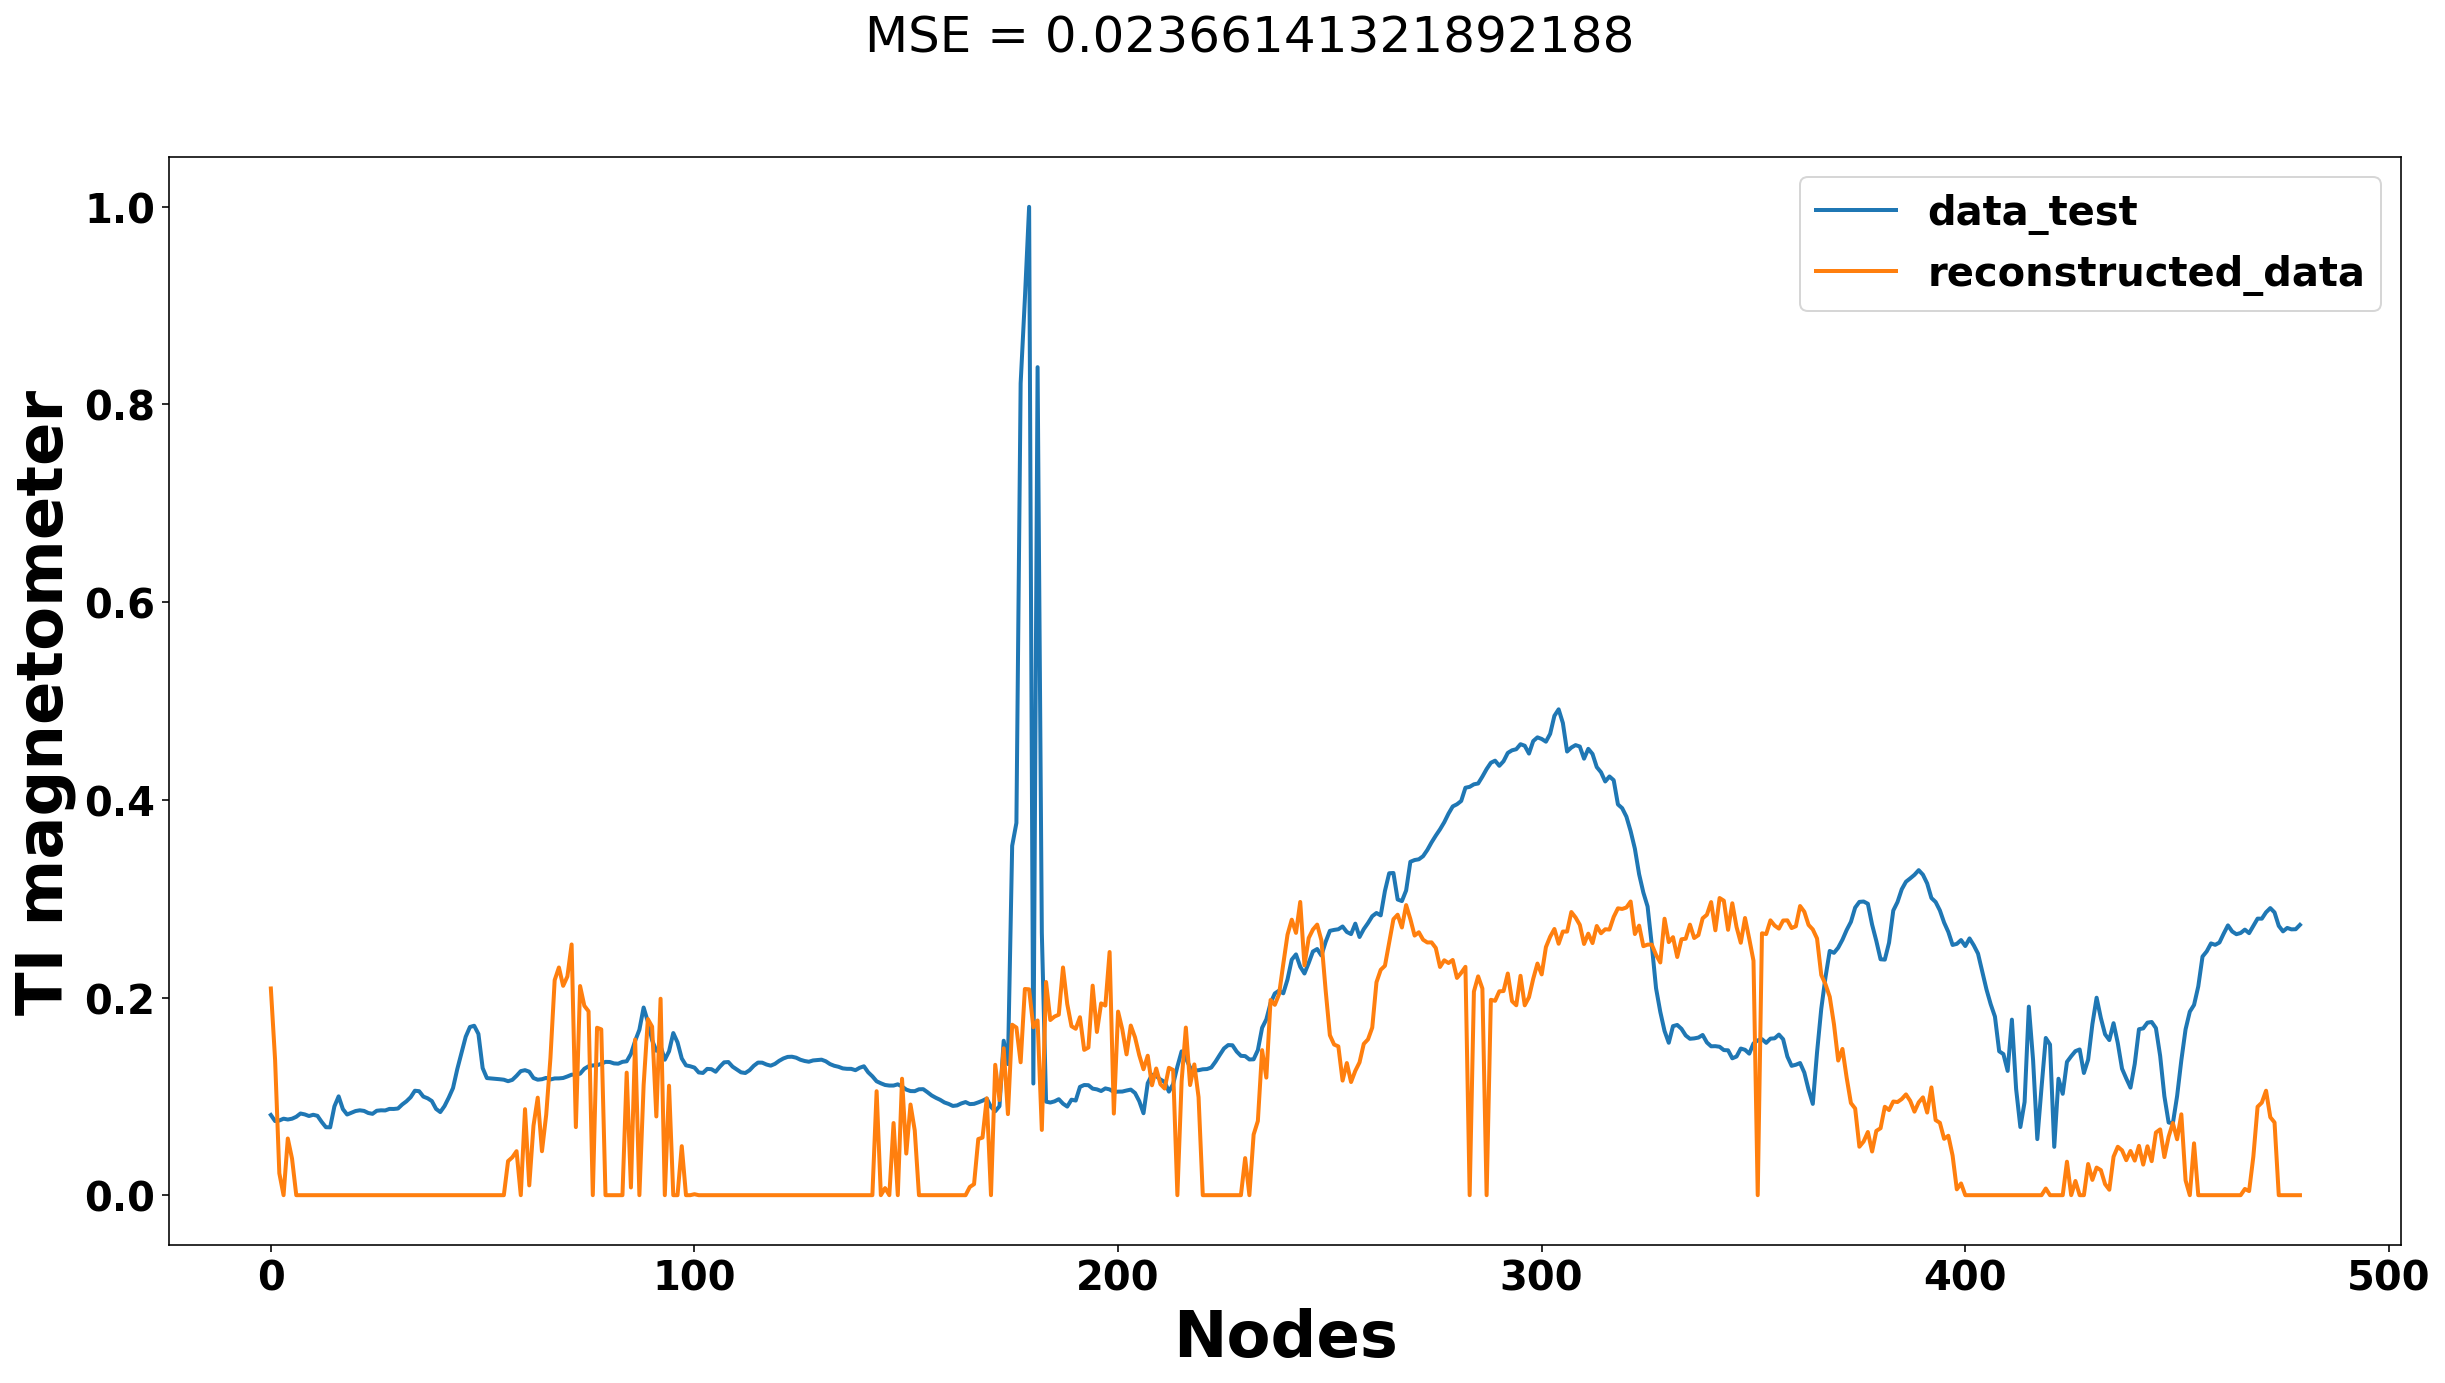

In [27]:
result_plot_false = pd.DataFrame({'data_test': data_test_false[0], 'reconstructed_data': reconstructed_data_false[0]})
data_plotting.plot_result(result_plot_false, 'Nodes', 'TI magnetometer', 20, parent_dir, '0p0014-16', 'different_location', mse_false)